In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  as ws
ws.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/diabetes-data-set/diabetes-dataset.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


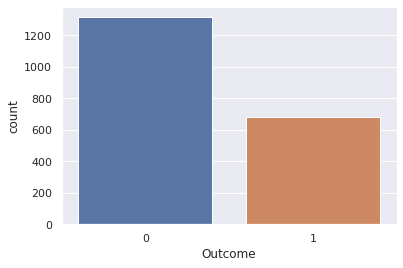

In [4]:
sns.set()
sns.countplot(df["Outcome"])
plt.show()

Above graph clearly shows the class imbalance 

In [5]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# Split the data 
from sklearn.model_selection import train_test_split
X = df.drop(columns = "Outcome")
y = df["Outcome"]
X_train , X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 42, stratify = y)


In [8]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Fitting the model to the training data
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

In [10]:
from sklearn.model_selection import KFold, cross_val_score
for model in [ 
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier,
]:
    cls = model()
    kf = KFold(n_splits = 5, random_state = 45)
    score = cross_val_score(cls, X_train_scaled, y_train, cv = kf, scoring="roc_auc")
    print(
        f"{model.__name__:22}  AUC: "
        
        f"\t {score.mean():.3f} STD: {score.std():.2f}"
        
    )

DummyClassifier         AUC: 	 0.499 STD: 0.04
LogisticRegression      AUC: 	 0.829 STD: 0.02
DecisionTreeClassifier  AUC: 	 0.951 STD: 0.02
KNeighborsClassifier    AUC: 	 0.875 STD: 0.02
GaussianNB              AUC: 	 0.814 STD: 0.02
SVC                     AUC: 	 0.878 STD: 0.03
RandomForestClassifier  AUC: 	 0.985 STD: 0.01
XGBClassifier           AUC: 	 0.973 STD: 0.02


In [11]:
# Withour any certain hyper param tuning the Random_Forest Model is best
# leta get model working

rfe = RandomForestClassifier(n_estimators=1000, random_state = 42)

In [12]:
rfe.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [13]:
# Evaluating the Random Forest Model
print ("Accuacy on test set is ", round(rfe.score(X_test_scaled, y_test) * 100, 2), "%")

Accuacy on test set is  98.5 %


In [14]:
from sklearn.metrics import precision_score
print("precision Score is ", round (precision_score(y_test, rfe.predict(X_test_scaled)) * 100 , 2))

precision Score is  97.81


In [15]:
print("Feature importance is \n" )
for i,j in zip(X_train.columns.to_list(), rfe.feature_importances_.tolist()):
    if(i == "DiabetesPedigreeFunction"):
        print (i , "\t \t ", j)
    elif(i=="Age" or i =="BMI"):
        print (i , "\t \t \t\t\t", j)
    else :   
        print (i , "\t \t \t \t", j)

Feature importance is 

Pregnancies 	 	 	 	 0.07890701694228258
Glucose 	 	 	 	 0.2555919391159016
BloodPressure 	 	 	 	 0.0917543694758791
SkinThickness 	 	 	 	 0.06786427718716934
Insulin 	 	 	 	 0.0752442185853682
BMI 	 	 			 0.16824692841318908
DiabetesPedigreeFunction 	 	  0.1242248432377123
Age 	 	 			 0.13816640704249777


In [16]:
# As we seleted the model we can try the hyperparam tuning
from sklearn.model_selection import GridSearchCV

new_rfe = RandomForestClassifier()

params = {
     "max_features": [0.4, "auto"],
     "n_estimators": [15, 200, 500, 1000],
     "min_samples_leaf": [1, 0.1],
     "random_state": [42],
}

cvs = GridSearchCV(new_rfe, params, n_jobs = -1).fit(X_train_scaled, y_train)

In [17]:
print(cvs.best_score_)

0.9637499999999999


In [18]:
print(cvs.best_estimator_)

RandomForestClassifier(max_features=0.4, n_estimators=1000, random_state=42)


In [19]:
print(cvs.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 1000, 'random_state': 42}


In [20]:
# fitting the model with best params
rfe_final = RandomForestClassifier(
**{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 1000, 'random_state': 42}
)

In [21]:
rfe_final.fit(X_train_scaled, y_train)

RandomForestClassifier(max_features=0.4, n_estimators=1000, random_state=42)

In [22]:
y_pred = rfe_final.predict(X_test_scaled)

In [23]:
print(precision_score(y_test, y_pred))

0.9781021897810219


In [24]:
from sklearn.metrics import confusion_matrix, classification_report

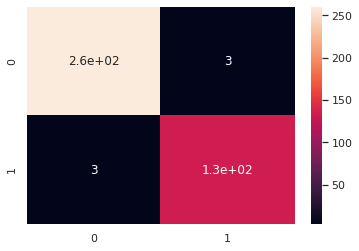

In [25]:
sns.set()
sns.heatmap(confusion_matrix(y_test, y_pred), annot =True)
plt.show()

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       263
           1       0.98      0.98      0.98       137

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [27]:
# print Roc_auc_score
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.983347672837279


# This is Cool :) 

Please upvote it !! It wll motivate me to create content more like this